#Version

### 1. LIBRARIES

In [3]:
!pip install Ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.9 MB/s eta 0:00:00


In [4]:
import os, math, cv2, numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode
from tqdm import tqdm
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### 2. CONFIG & PATHS

In [30]:
video_path   = "/FootFall.mp4"
output_video = "/output_station.mp4"
screens_dir  = "/content/screens"
os.makedirs(screens_dir, exist_ok=True)

# Tripwire configuration
COUNT_LINE = (938, 1059, 1611, 80)
DIRECTION_IN = ('B','A')

# YOLO model settings
MODEL_WEIGHTS = "yolov8x.pt"
TRACKER       = "botsort.yaml"
CONF          = 0.25
IOU           = 0.45
IMG_SIZE      = 1280

# Detection filtering
MIN_BOX_H     = 12
MIN_BOX_W     = 8
MAX_BOX_RATIO = 4.0

# Tracking logic
TRACKING_POINT = 'adaptive'
COOLDOWN_FRAMES = 15
MIN_MOTION      = 3

# Visualization colors
COL_IN, COL_OUT, COL_BOX, COL_LINE = (0,200,0), (0,140,255), (255,255,255), (0,255,255)
SAVE_SNAPS_EVERY = 60

DEVICE = 0 if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE} ({'GPU' if DEVICE != 'cpu' else 'CPU'})")
print(f"Model: {MODEL_WEIGHTS}, Conf: {CONF}, Tracking: {TRACKING_POINT}")

Device: 0 (GPU)
Model: yolov8x.pt, Conf: 0.25, Tracking: adaptive


### QUICK PREVIEW

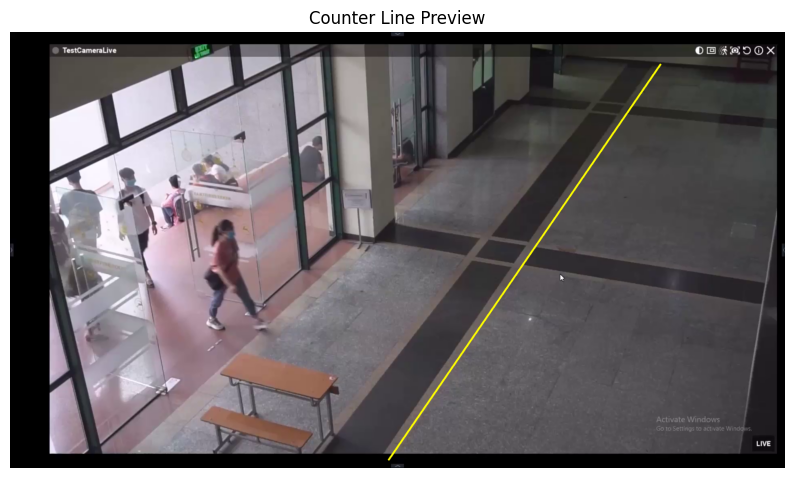

In [31]:
cap = cv2.VideoCapture(video_path)
ok, frame0 = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Couldn't read first frame. Check your video path.")

# line for visual confirmation
preview = frame0.copy()
x1, y1, x2, y2 = map(int, COUNT_LINE)
cv2.line(preview, (x1, y1), (x2, y2), COL_LINE, 3)

# Displaying the frame
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Counter Line Preview")
plt.show()

### 3. CORE UTILITIES

In [32]:
def get_tracking_point(xyxy, method='adaptive'):
    """Chooses best tracking point depending on box shape or camera angle."""
    x1, y1, x2, y2 = map(float, xyxy)
    cx = (x1 + x2) / 2.0
    if method == 'foot': return (cx, y2)
    if method == 'center': return (cx, (y1 + y2) / 2.0)
    h, w = y2 - y1, x2 - x1
    ratio = h / max(w, 1.0)
    if ratio > 1.5: return (cx, y2)
    return (cx, y1 + 0.7 * h)

def is_valid_detection(xyxy, min_h=MIN_BOX_H, min_w=MIN_BOX_W, max_ratio=MAX_BOX_RATIO):
    """Reject boxes too small or oddly shaped."""
    x1, y1, x2, y2 = map(float, xyxy)
    w, h = x2 - x1, y2 - y1
    if h < min_h or w < min_w: return False
    ratio = h / max(w, 1.0)
    return not (ratio > max_ratio or ratio < (1.0 / max_ratio))

def annotate(frame, box, track_id, pt, color, show_box_info=False):
    """Draw bounding box, ID label, and tracking point."""
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    label = f"ID {int(track_id)}"
    if show_box_info:
        h, w = y2 - y1, x2 - x1
        label += f" {w}x{h}"
    cv2.putText(frame, label, (x1, max(18, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.circle(frame, (int(pt[0]), int(pt[1])), 4, color, -1)

def draw_Counting_line(frame, line, color=COL_LINE):
    """Draw The Counter Line."""
    x1, y1, x2, y2 = map(int, line)
    cv2.line(frame, (x1, y1), (x2, y2), color, 3)

def side_of_line(p, a, b):
    """Returns +1, -1 , or 0 (on line)."""
    (px, py), (x1, y1), (x2, y2) = p, a, b
    val = (x2 - x1) * (py - y1) - (y2 - y1) * (px - x1)
    return 1 if val > 0 else (-1 if val < 0 else 0)

def seg_intersects(p1, p2, q1, q2):
    """Checks if path p1→p2 intersects line q1→q2."""
    def orient(a,b,c): return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])
    def on_seg(a,b,c):
        return min(a[0],b[0])-1e-6 <= c[0] <= max(a[0],b[0])+1e-6 and \
               min(a[1],b[1])-1e-6 <= c[1] <= max(a[1],b[1])+1e-6
    o1, o2 = orient(p1,p2,q1), orient(p1,p2,q2)
    o3, o4 = orient(q1,q2,p1), orient(q1,q2,p2)
    if (o1==0 and on_seg(p1,p2,q1)) or (o2==0 and on_seg(p1,p2,q2)) \
       or (o3==0 and on_seg(q1,q2,p1)) or (o4==0 and on_seg(q1,q2,p2)): return True
    return (o1>0)!=(o2>0) and (o3>0)!=(o4>0)

### COUNTER

In [33]:
class Counter:
    """
    Handling IN/OUT counting using the line-crossing method.
    Uses ID-based cooldowns and motion thresholds to avoid duplicate counts.
    """

    def __init__(self, line_xyxy, cooldown_frames=COOLDOWN_FRAMES, min_motion=MIN_MOTION):
        x1, y1, x2, y2 = map(float, line_xyxy)
        self.A, self.B = (x1, y1), (x2, y2)
        self.cooldown = int(cooldown_frames)
        self.min_motion = float(min_motion)
        self.prev_pt, self.last_count_frame = {}, {}
        self.count_in = self.count_out = 0
        self.frame_idx = 0
        self.total_tracked = 0
        self.skipped_motion = 0
        self.skipped_cooldown = 0

    def set_frame(self, i):
        self.frame_idx = int(i)

    def update(self, tid, p_now, direction_in=('A','B')):
        """Update counter per person-ID per frame."""
        if tid not in self.prev_pt:
            self.prev_pt[tid] = p_now
            self.total_tracked += 1
            return None

        p_prev = self.prev_pt[tid]
        motion = math.hypot(p_now[0] - p_prev[0], p_now[1] - p_prev[1])
        if motion < self.min_motion:
            self.prev_pt[tid] = p_now
            self.skipped_motion += 1
            return None

        crossed = seg_intersects(p_prev, p_now, self.A, self.B)
        event = None
        if crossed:
            if self.frame_idx - self.last_count_frame.get(tid, -10_000) < self.cooldown:
                self.prev_pt[tid] = p_now
                self.skipped_cooldown += 1
                return None

            s_prev = side_of_line(p_prev, self.A, self.B)
            s_now  = side_of_line(p_now, self.A, self.B)
            if s_prev == 0 or s_now == 0:
                mid = ((p_prev[0]+p_now[0])*0.5, (p_prev[1]+p_now[1])*0.5)
                s_prev = side_of_line(mid, self.A, self.B)
                s_now  = -s_prev

            prev_label = 'A' if s_prev > 0 else 'B'
            now_label  = 'A' if s_now  > 0 else 'B'

            if (prev_label, now_label) == tuple(direction_in):
                self.count_in += 1; event = 'in'
            else:
                self.count_out += 1; event = 'out'

            self.last_count_frame[tid] = self.frame_idx

        self.prev_pt[tid] = p_now
        return event

### MODEL SETUP

In [34]:
model = YOLO(MODEL_WEIGHTS)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open video: {video_path}")
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS) or 25.0
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
cap.release()

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_video, fourcc, FPS, (W, H))

counter = Counter(COUNT_LINE, cooldown_frames=COOLDOWN_FRAMES, min_motion=MIN_MOTION)

### MAIN PROCESSING


 Processing...
   Model: yolov8x.pt
   Tracker: botsort.yaml
   Conf: 0.25, IOU: 0.45
   Tracking point: adaptive
   Min box: 8x12, Max ratio: 4.0



  0%|          | 0/159 [00:00<?, ?it/s]

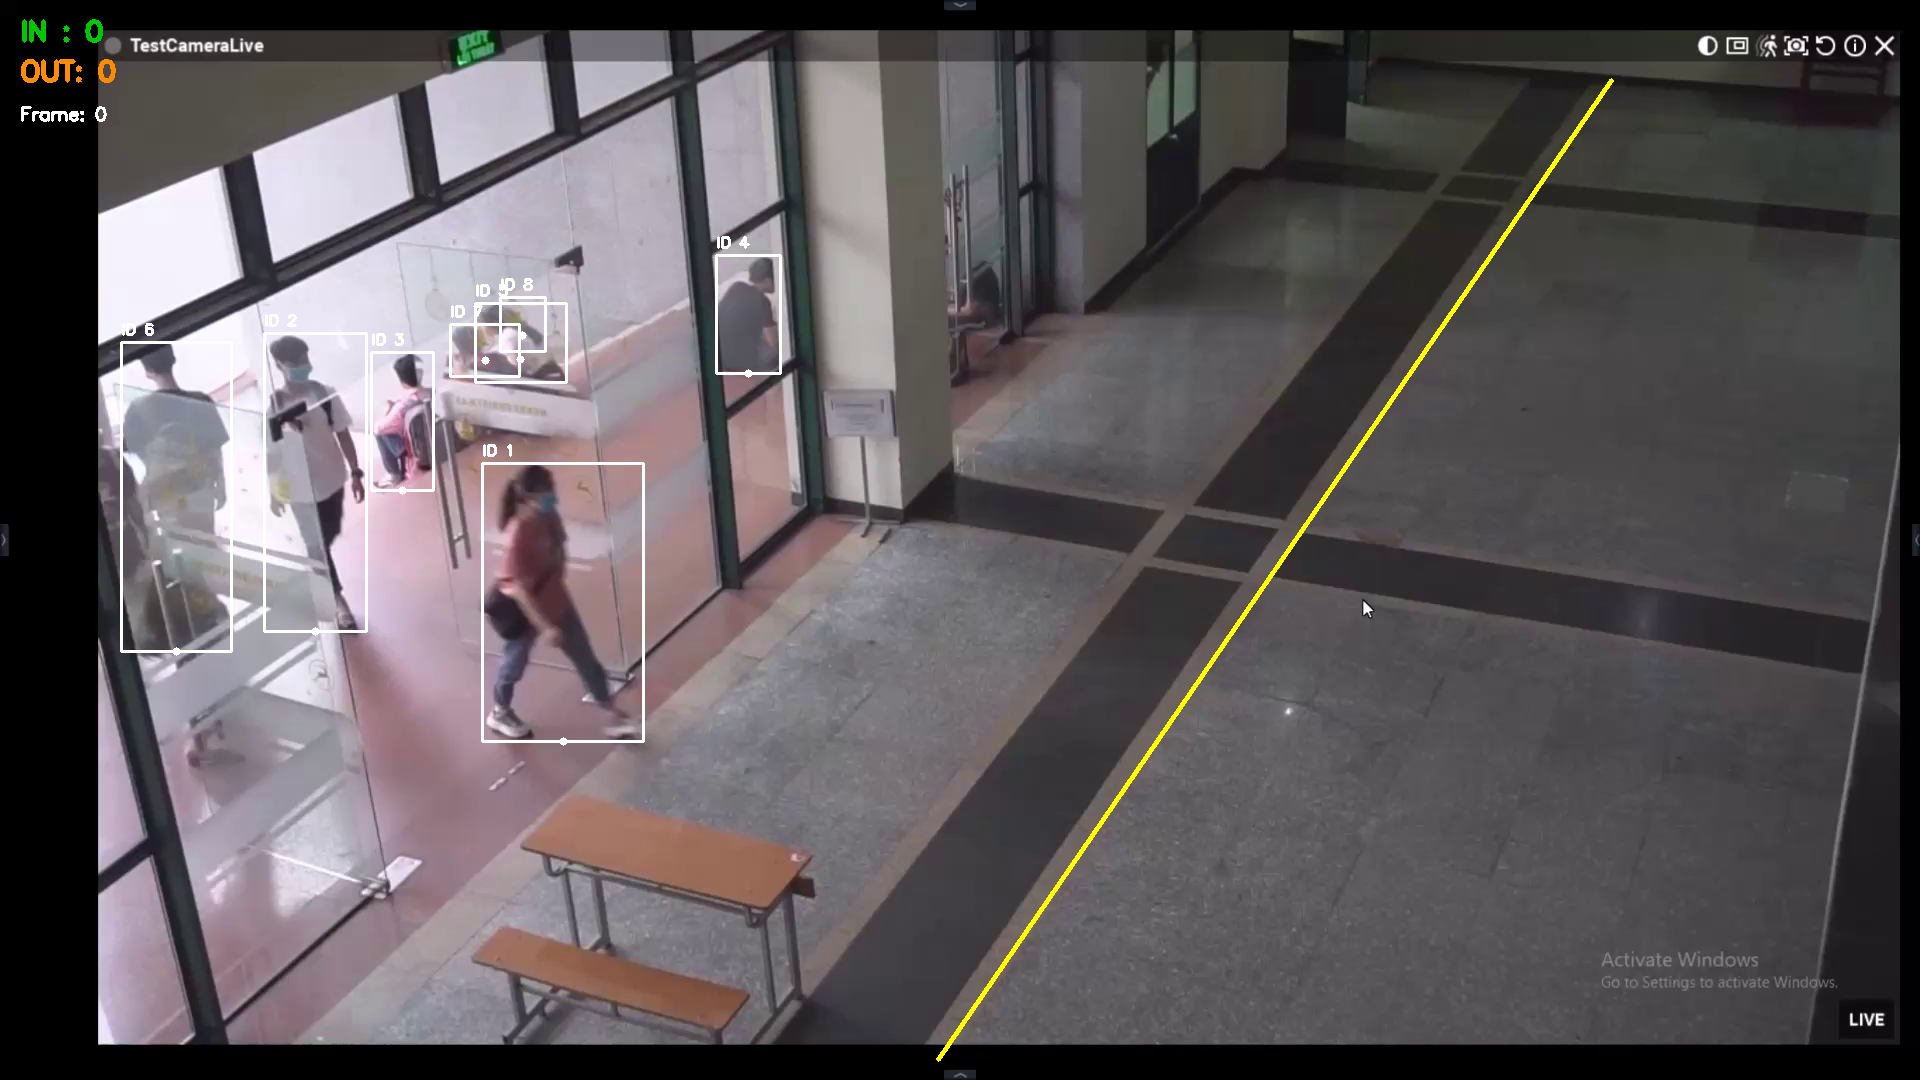

100%|██████████| 159/159 [00:32<00:00,  4.92it/s]


In [35]:
results = model.track(
    source=video_path,
    stream=True,
    persist=True,
    tracker=TRACKER,
    conf=CONF,
    iou=IOU,
    classes=[0],
    verbose=False,
    imgsz=IMG_SIZE,
    device=DEVICE
)

print(f"\n Processing...")
print(f"   Model: {MODEL_WEIGHTS}")
print(f"   Tracker: {TRACKER}")
print(f"   Conf: {CONF}, IOU: {IOU}")
print(f"   Tracking point: {TRACKING_POINT}")
print(f"   Min box: {MIN_BOX_W}x{MIN_BOX_H}, Max ratio: {MAX_BOX_RATIO}\n")

detected_people = 0
filtered_out = 0


for i, r in enumerate(tqdm(results, total=total_frames if total_frames>0 else None)):
    frame = r.orig_img.copy()
    counter.set_frame(i)

    draw_Counting_line(frame, COUNT_LINE, COL_LINE)
    cv2.putText(frame, f"IN : {counter.count_in}",  (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, COL_IN, 3)
    cv2.putText(frame, f"OUT: {counter.count_out}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.9, COL_OUT, 3)
    cv2.putText(frame, f"Frame: {i}", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    if r.boxes is not None and r.boxes.id is not None:
        xyxy = r.boxes.xyxy.cpu().numpy()
        tids = r.boxes.id.cpu().numpy().astype(int)
        cls  = r.boxes.cls.cpu().numpy().astype(int)
        for j, c in enumerate(cls):
            if c != 0: continue
            if not is_valid_detection(xyxy[j]):
                filtered_out += 1; continue
            detected_people += 1
            pt = get_tracking_point(xyxy[j], method=TRACKING_POINT)
            event = counter.update(tids[j], pt, direction_in=DIRECTION_IN)
            color = COL_IN if event == "in" else (COL_OUT if event == "out" else COL_BOX)
            annotate(frame, xyxy[j], tids[j], pt, color)
    writer.write(frame)

    if i % SAVE_SNAPS_EVERY == 0:
        cv2.imwrite(os.path.join(screens_dir, f"frame_{i:06d}.jpg"), frame)
    if i % 200 == 0:
        cv2_imshow(frame)

writer.release()
cv2.destroyAllWindows()

### SUMMARY & INLINE PLAYBACK

In [36]:
print("\n" + "="*60)
print(" PROCESSING COMPLETE")
print("="*60)
print(f"\n Results:")
print(f"   IN : {counter.count_in}")
print(f"   OUT: {counter.count_out}")
print(f"   NET: {counter.count_in - counter.count_out}")
print(f"\n DETECTION STATS:")
print(f"   Total detections: {detected_people}")
print(f"   Filtered out: {filtered_out}")
print(f"   Unique IDs tracked: {counter.total_tracked}")
print(f"\n Saved video: {output_video}")
print("="*60)



 PROCESSING COMPLETE

 Results:
   IN : 4
   OUT: 0
   NET: 4

 DETECTION STATS:
   Total detections: 1316
   Filtered out: 16
   Unique IDs tracked: 23

 Saved video: /content/notebook/datasets/output_station.mp4
